In [36]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import *
import json

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind")

def load_df(p: Path) -> pd.DataFrame:
    data = pd.read_csv(p)
    times = data["IterTime"]
    t_sum = 0.0
    for i in range(0, len(times)):
        t_sum += times[i]
        times[i] = t_sum
    data["Bandwidth"] /= 1000.0
    return data

def load_ftq(p: Path, i:int) -> pd.DataFrame:
    #times = list(map(lambda s: int(s), (p/ f"ftq_{i}_times.dat").read_text().splitlines()))
    counts = list(map(lambda s: int(s), (p/ f"ftq_{i}_counts.dat").read_text().splitlines()))
    times = list(range(0, len(counts)))
    data = pd.DataFrame()
    data["Times"] = times
    #times = data["Times"]
    #times -= times[0]
    data["Counts"] = counts
    data = data.assign(core=str(i))
    return data

import itertools
import operator
def load_ftqs(p: Path, count: int) -> pd.DataFrame:
    #return itertools.accumulate(map(lambda i: load_ftq(p, i), range(0, count)), operator.add)
    return pd.concat(map(lambda i: load_ftq(p, i), range(0, count)))
    pd.DataFrame()
    data = pd.read_csv(p)
    times = data["Times"]
    times -= times[0]
    #start_time = times[0]
    #for i in range(1, len(times)):
        #times[i] -= start_time
    print(data)
    data.drop(index=0)
    print(data)
    return data
def sum_ftqs(p: Path, count: int) -> pd.DataFrame:
    df = load_ftq(p, 0)
    for i in range(1,count):
        df["Counts"] += load_ftq(p, i)["Counts"]
        print(df.size)
    return df

def load_ftqs_batched(p: Path, count: int, samples: int) -> pd.DataFrame:
    #times = list(map(lambda s: int(s), (p/ f"ftq_{i}_times.dat").read_text().splitlines()))
    out = pd.DataFrame()
    counts = list(map(lambda s: int(s), (p/ "counts.dat").read_text().splitlines()))
    for i in range(0, count):
        times = list(range(0, samples))
        data = pd.DataFrame()
        data["Times"] = times
        #times = data["Times"]
        #times -= times[0]
        data["Counts"] = counts[(samples*i):(samples*(i+1))]
        data = data.assign(core=str(i))
        out = pd.concat([out,data])
    return out

def sum_ftqs_batched(p: Path, count: int, samples: int) -> pd.DataFrame:
    out = pd.DataFrame()
    counts = list(map(lambda s: int(s), (p/ "counts.dat").read_text().splitlines()))
    times = list(map(lambda s: int(s), (p/ "times.dat").read_text().splitlines()))
    for i in range(0, count):
        #times = list(range(0, samples))
        data = pd.DataFrame()
        data["Times"] = times[(samples*i):(samples*(i+1))]
        #times = data["Times"]
        #times -= times[0]
        data["Counts"] = counts[(samples*i):(samples*(i+1))]
        data = data.assign(core=str(i))
        if i == 0:
            out = data
        else:
            out += data#pd.concat([out,data])
    return out

In [67]:
def plot_core_configs(path: Path, cores: list[int], do_plot: Callable[[Path, int, any], None]):
    fig, axes = plt.subplots(1, len(cores), figsize=(40,5))
    for i, c in enumerate(cores):
        do_plot(path, c, axes[i])

def plot_stream(path: Path, cores: int, axis: any):
    file = Path(f"{cores}/Copy.csv")
    virtio_balloon = load_df(path / "latest-virtio-balloon-stream" / file)
    virtio_balloon_huge = load_df(path / "latest-virtio-balloon-huge-stream" / file)
    virtio_mem = load_df(path / "latest-virtio-mem-stream" / file)
    llfree = load_df(path / "latest-llfree-stream" / file)
    concat = pd.concat([virtio_balloon.assign(driver="virtio-ballon"), virtio_balloon_huge.assign(driver="virtio-ballon-huge"), virtio_mem.assign(driver="virtio-mem"), llfree.assign(driver="llfree")])
    plot = sns.scatterplot(x="IterTime", y="Bandwidth", data=concat, hue="driver", s=10.0, ax=axis)
    #plot.set_ylim(0.0, 13.0)
    #plot.set_xlim(0.0, 20)
    plot.set_ylim(0.0)
    axis.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    #plot.set_yticklabels(plot.get_yticks().astype(int))
    plot.set_ylabel("Bandwith [GB/s]")
    plot.set_xlabel("Runtime [s]")
    plot.set_title(f"STREAM {cores}/12")
    plot.get_legend().set_visible(False)

def plot_ftq(path: Path, cores: int, axis: any):
    sub = f"{cores}"
    virtio_balloon = sum_ftqs_batched(path / "latest-virtio-balloon-ftq" / sub, cores, 1000)
    virtio_balloon_huge = sum_ftqs_batched(path / "latest-virtio-balloon-huge-ftq" / sub, cores, 1000)
    virtio_mem = sum_ftqs_batched(path / "latest-virtio-mem-ftq" / sub, cores, 1000)
    llfree = sum_ftqs_batched(path / "latest-llfree-ftq" / sub, cores, 1000)
    concat = pd.concat([virtio_balloon.assign(driver="virtio-ballon"), virtio_balloon_huge.assign(driver="virtio-ballon-huge"), virtio_mem.assign(driver="virtio-mem"), llfree.assign(driver="llfree")])
    plot = sns.scatterplot(x="Times", y="Counts", data=concat, hue="driver", s=10.0, ax=axis)
    #plot.set_ylim(0.0, 13.0)
    plot.set_ylim(0.0)
    #plot.set_xlim(0.0, 20)
    plot.set_ylabel("Work")
    plot.set_xlabel("Cycles")
    plot.set_title(f"FTQ {cores}/12")
    plot.get_legend().set_visible(False)

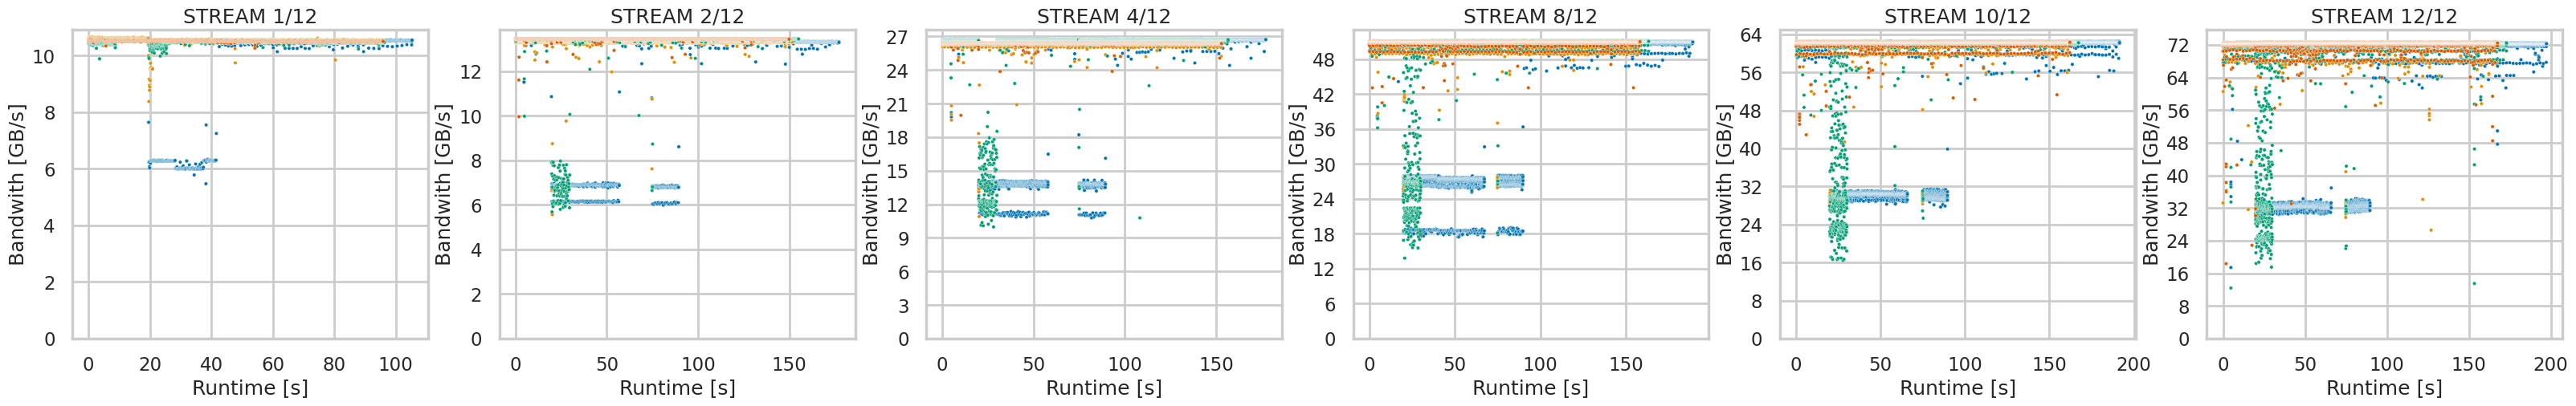

In [68]:
plot_core_configs(Path("stream"), [1, 2, 4, 8, 10, 12], plot_stream)

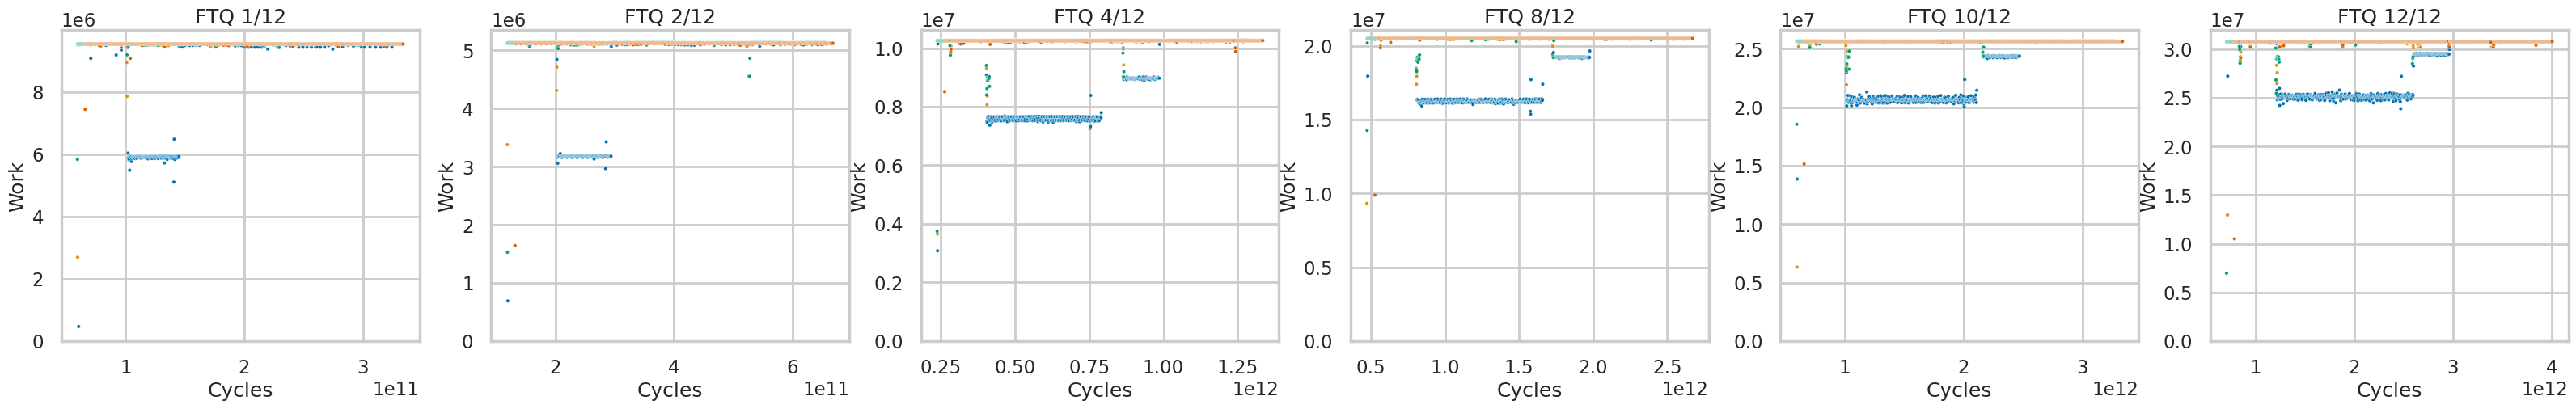

In [66]:
plot_core_configs(Path("stream"), [1, 2, 4, 8, 10, 12], plot_ftq)